In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import missingno as msno

# Load S&P 500 historical data
sp500_data = pd.read_csv(r'C:\Users\srine\Downloads\Newssentiment\SP500_Historical_Data.csv')

# Load News Sentiment data
news_sentiment = pd.read_csv(r'C:\Users\srine\Downloads\Newssentiment\News_Sentiment.csv')

# Check the first few rows of the data
print(sp500_data.head())
print(news_sentiment.head())

# Convert the 'Date' column to datetime format for both datasets
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
news_sentiment['Date'] = pd.to_datetime(news_sentiment['Date'])

# Merge the two datasets on the 'Date' column
merged_data = pd.merge(sp500_data[['Date', 'Close']], news_sentiment[['Date', 'Sentiment']], on='Date')

# Set the 'Date' column as the index
merged_data.set_index('Date', inplace=True)

# Display the first few rows of the merged data
print(merged_data.head())


         Date    Open    High     Low   Close      Volume
0  1980-01-02  107.94  108.43  105.29  105.76  22561111.0
1  1980-01-03  105.76  106.08  103.26  105.22  28044444.0
2  1980-01-04  105.22  107.08  105.09  106.52  21738889.0
3  1980-01-07  106.52  107.80  105.80  106.81  24722222.0
4  1980-01-08  106.81  109.29  106.29  108.95  29661111.0
       Date  Sentiment
0  1/1/1980      -0.04
1  1/2/1980      -0.11
2  1/3/1980      -0.09
3  1/5/1980      -0.07
4  1/6/1980      -0.09
             Close  Sentiment
Date                         
1980-01-02  105.76      -0.11
1980-01-03  105.22      -0.09
1980-01-07  106.81      -0.13
1980-01-08  108.95      -0.20
1980-01-09  109.05      -0.22


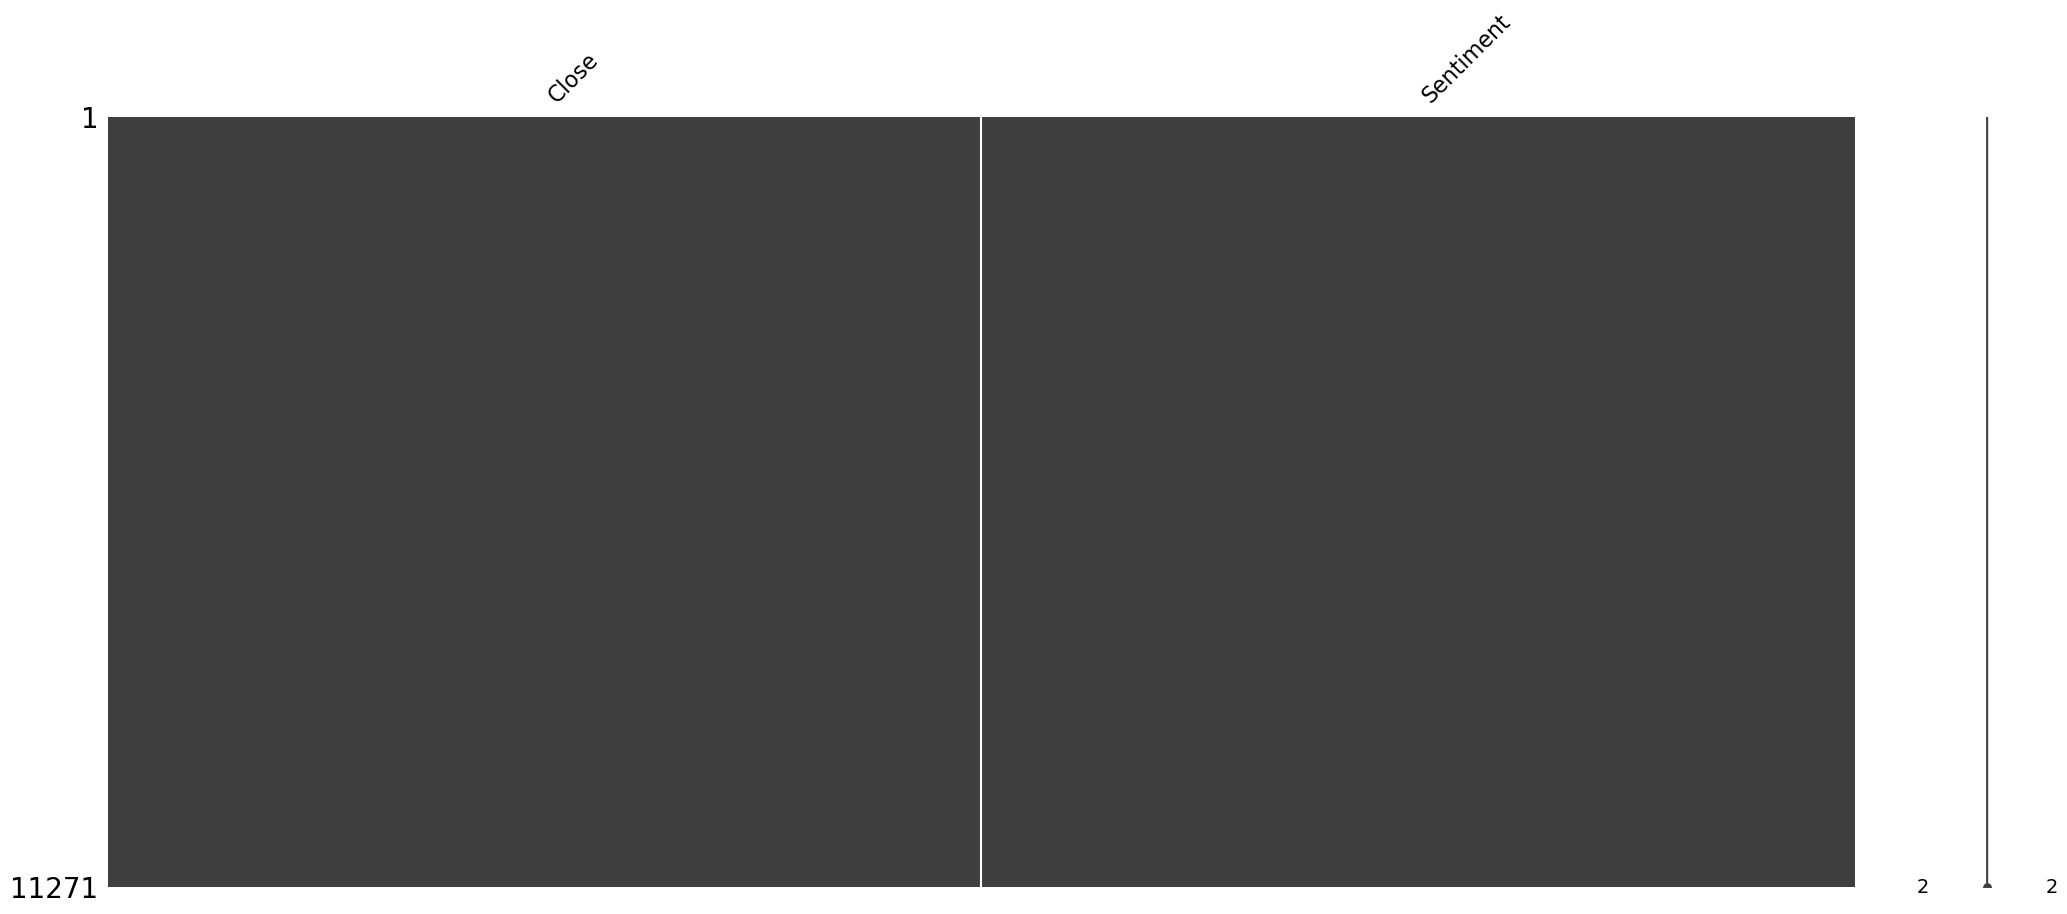

Close        0
Sentiment    0
dtype: int64


C:\Users\srine\AppData\Local\Temp\ipykernel_17600\236376942.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data.fillna(method='ffill', inplace=True)


In [103]:
#Handling missing data

# Visualize missing data
msno.matrix(merged_data)
plt.show()

# Fill missing values using forward fill (or other imputation methods as needed)
merged_data.fillna(method='ffill', inplace=True)

# Check for any remaining missing values
print(merged_data.isnull().sum())


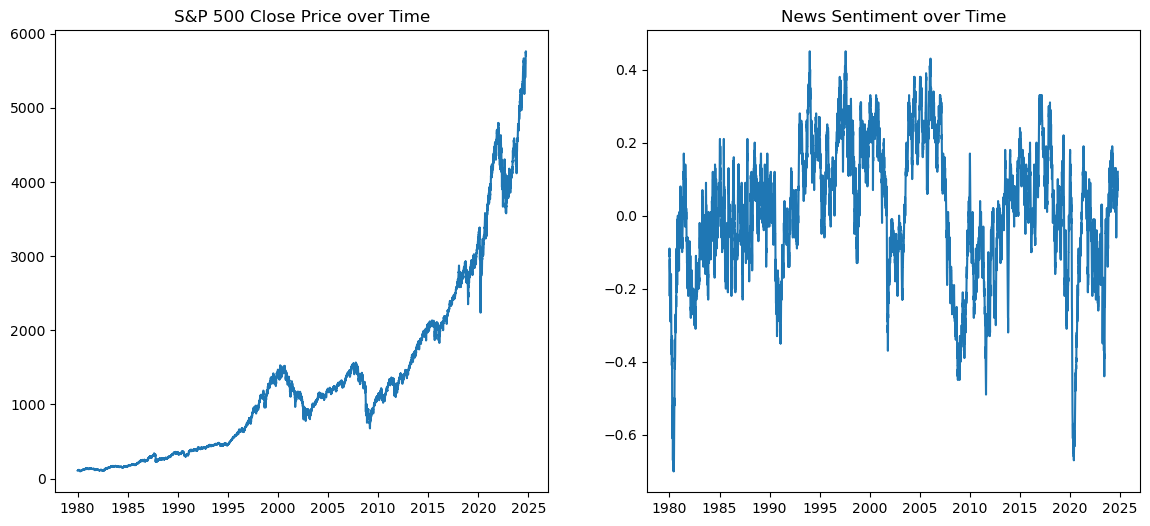

In [105]:
#Visualizing the S&P 500 Prices and Sentiment Scores


# Plot the S&P 500 close price and sentiment over time
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(merged_data['Close'], label='S&P 500 Close Price')
plt.title('S&P 500 Close Price over Time')
plt.subplot(1, 2, 2)
plt.plot(merged_data['Sentiment'], label='News Sentiment')
plt.title('News Sentiment over Time')
plt.show()


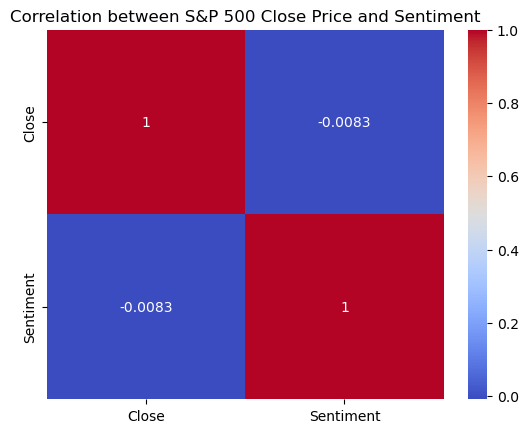

In [107]:
#Correlation Analysis

# Correlation heatmap between Close price and Sentiment
corr = merged_data[['Close', 'Sentiment']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation between S&P 500 Close Price and Sentiment')
plt.show()


In [109]:
#We need to normalize the data because models like LSTM, GRU, and CNN-LSTM perform better when the features are scaled between 0 and 1.


# Normalize Close price and Sentiment using MinMaxScaler
scaler_price = MinMaxScaler(feature_range=(0, 1))
scaler_sentiment = MinMaxScaler(feature_range=(0, 1))

merged_data['Close'] = scaler_price.fit_transform(merged_data[['Close']])
merged_data['Sentiment'] = scaler_sentiment.fit_transform(merged_data[['Sentiment']])

# Check the normalized data
print(merged_data.head())


               Close  Sentiment
Date                           
1980-01-02  0.001331   0.513043
1980-01-03  0.001236   0.530435
1980-01-07  0.001517   0.495652
1980-01-08  0.001894   0.434783
1980-01-09  0.001912   0.417391


In [111]:
# Function to create sequences for time series data
def create_sequences(data_close, data_sentiment, time_step=60):
    X, y = [], []
    for i in range(len(data_close) - time_step - 1):
        X.append(np.hstack((data_close[i:i + time_step], data_sentiment[i:i + time_step])))
        y.append(data_close[i + time_step, 0])
    return np.array(X), np.array(y)

# Prepare data for training
time_step = 60
close_data = merged_data['Close'].values.reshape(-1, 1)
sentiment_data = merged_data['Sentiment'].values.reshape(-1, 1)

# Create sequences for X (input) and y (target)
X, y = create_sequences(close_data, sentiment_data, time_step)

# Split data into training and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [113]:
#Model 1: LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# LSTM model
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train and evaluate LSTM
lstm_model = build_lstm_model()
history_lstm = lstm_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))



C:\Users\srine\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 88ms/step - loss: 0.0036 - val_loss: 7.9786e-04
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 2.7779e-04 - val_loss: 0.0016
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 2.2982e-04 - val_loss: 0.0010
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 1.9919e-04 - val_loss: 7.5293e-04
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - loss: 1.5832e-04 - val_loss: 0.0018
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - loss: 1.6173e-04 - val_loss: 0.0028
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 1.4766e-04 - val_loss: 0.0011
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - loss: 1.4170e-04 - val_loss: 0.0030
Epoch 9/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 1.1326e-04 - val_loss: 0.0020
Epoch 10/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 1.2390e-04 - val_loss: 0.0020
Epoch 11/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 1.1132e-04 - val_

In [89]:
#Step 3: Model 2: GRU

from tensorflow.keras.layers import GRU

# GRU model
def build_gru_model():
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(GRU(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train and evaluate GRU
gru_model = build_gru_model()
history_gru = gru_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

C:\Users\srine\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - loss: 0.0095 - val_loss: 3.2754e-04
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 4.0671e-04 - val_loss: 2.8001e-04
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 2.7914e-04 - val_loss: 2.5773e-04
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 2.4053e-04 - val_loss: 2.8167e-04
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 2.0185e-04 - val_loss: 2.8206e-04
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 1.9631e-04 - val_loss: 1.3872e-04
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - loss: 1.6248e-04 - val_loss: 2.4970e-04
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 1.5737e-04 - val_loss: 1.8910e-04
Epoch 9/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 1.4514e-04 - val_loss: 6.0039e-04
Epoch 10/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - loss: 1.3729e-04 - val_loss: 2.7465e-04
Epoch 11/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 11

In [91]:
#Model 3: CNN-LSTM

from tensorflow.keras.layers import Conv1D, MaxPooling1D

# CNN-LSTM model
def build_cnn_lstm_model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train and evaluate CNN-LSTM
cnn_lstm_model = build_cnn_lstm_model()
history_cnn_lstm = cnn_lstm_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))


C:\Users\srine\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.2260e-04 - val_loss: 0.0030
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 1.8291e-04 - val_loss: 0.0021
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 1.6453e-04 - val_loss: 0.0030
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 1.3652e-04 - val_loss: 0.0040
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.2973e-04 - val_loss: 0.0052
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.1761e-04 - val_loss: 0.0047
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1.1107e-04 - val_loss: 0.0030
Epoch 9/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.0328e-04 - val_loss: 0.0035
Epoch 10/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 9.9353e-05 - val_loss: 0.0056
Epoch 11/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 8.6636e-05 - val_loss: 0.0054
E

In [93]:
from sklearn.metrics import mean_squared_error

# Make predictions using each model
y_pred_lstm = lstm_model.predict(X_test)
y_pred_gru = gru_model.predict(X_test)
y_pred_cnn_lstm = cnn_lstm_model.predict(X_test)

# Rescale predictions and true values back to original scale
y_test_rescaled = scaler_price.inverse_transform(y_test.reshape(-1, 1))
y_pred_lstm_rescaled = scaler_price.inverse_transform(y_pred_lstm)
y_pred_gru_rescaled = scaler_price.inverse_transform(y_pred_gru)
y_pred_cnn_lstm_rescaled = scaler_price.inverse_transform(y_pred_cnn_lstm)

# Calculate Mean Squared Error (MSE) for each model
mse_lstm = mean_squared_error(y_test_rescaled, y_pred_lstm_rescaled)
mse_gru = mean_squared_error(y_test_rescaled, y_pred_gru_rescaled)
mse_cnn_lstm = mean_squared_error(y_test_rescaled, y_pred_cnn_lstm_rescaled)

print(f"LSTM MSE: {mse_lstm}")
print(f"GRU MSE: {mse_gru}")
print(f"CNN-LSTM MSE: {mse_cnn_lstm}")


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
LSTM MSE: 0.00059469544962178
GRU MSE: 0.0001652577960072495
CNN-LSTM MSE: 0.00559706412811718


In [95]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Function to build the GRU model with tunable hyperparameters
def build_gru_model(hp):
    model = Sequential()

    # Tune number of GRU units
    units = hp.Int('units', min_value=32, max_value=256, step=32)
    model.add(GRU(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    
    # Tune dropout rate
    dropout_rate = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_rate))
    
    model.add(GRU(units=units))
    model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))

    # Tune learning rate for the Adam optimizer
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    
    return model


In [65]:
# Instantiate the tuner
tuner = kt.RandomSearch(
    build_gru_model,
    objective='val_loss',  # Minimize validation loss (MSE)
    max_trials=10,  # Number of hyperparameter sets to try
    executions_per_trial=2,  # Try each hyperparameter combination twice
    directory='my_tuner_dir',  # Directory where tuner results are saved
    project_name='gru_tuning'  # Name of the tuning project
)

# Display a summary of the search space
tuner.search_space_summary()


Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


C:\Users\srine\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [67]:
# Run the hyperparameter search
tuner.search(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The best number of units is: {best_hps.get('units')}")
print(f"The best dropout rate is: {best_hps.get('dropout')}")
print(f"The best learning rate is: {best_hps.get('learning_rate')}")


Trial 10 Complete [00h 31m 48s]
val_loss: 0.03427459509111941

Best val_loss So Far: 7.372477921308018e-05
Total elapsed time: 02h 44m 17s
The best number of units is: 224
The best dropout rate is: 0.1
The best learning rate is: 0.001411348024061337


In [97]:
# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

# Make predictions using the best model
y_pred_gru_best = best_model.predict(X_test)

# Rescale predictions and true values back to original scale
y_pred_gru_best_rescaled = scaler_price.inverse_transform(y_pred_gru_best)
y_test_rescaled = scaler_price.inverse_transform(y_test.reshape(-1, 1))

# Calculate MSE for the tuned GRU model
mse_gru_best = mean_squared_error(y_test_rescaled, y_pred_gru_best_rescaled)
print(f"Tuned GRU MSE: {mse_gru_best}")


C:\Users\srine\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 248ms/step - loss: 0.0065 - val_loss: 3.2011e-04
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 38s 267ms/step - loss: 6.7939e-05 - val_loss: 9.0563e-05
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 35s 249ms/step - loss: 5.3750e-05 - val_loss: 8.6434e-05
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 36s 252ms/step - loss: 5.2698e-05 - val_loss: 9.2209e-05
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 36s 253ms/step - loss: 4.5409e-05 - val_loss: 9.2127e-05
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 37s 259ms/step - loss: 4.0061e-05 - val_loss: 1.6158e-04
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 37s 262ms/step - loss: 4.3580e-05 - val_loss: 8.3881e-05
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 36s 258ms/step - loss: 3.4439e-05 - val_loss: 2.2168e-04
Epoch 9/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 38s 271ms/step - loss: 4.5063e-05 - val_loss: 9.1052e-05
Epoch 10/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 41s 290ms/step - loss: 3.6160e-05 - val_loss: 3.4722e-04
Epoch 11/20
141/141 ━━━━━━━━━━━━━

In [99]:
print(f"Original GRU MSE: {mse_gru}")
print(f"Tuned GRU MSE: {mse_gru_best}")

Original GRU MSE: 0.0001652577960072495
Tuned GRU MSE: 6.77510549612605e-05


In [115]:
# Predict future stock prices (e.g., for the next 10 days)
def predict_future_prices(model, input_data, steps=10):
    predictions = []
    current_input = input_data[-1]  # Start with the last known data point
    
    for _ in range(steps):
        current_input_reshaped = current_input.reshape((1, current_input.shape[0], current_input.shape[1]))
        next_pred = model.predict(current_input_reshaped)  # Predict the next stock price
        
        predictions.append(next_pred[0][0])  # Store the prediction
        
        # Update the input data by appending the new prediction and removing the first element
        next_input = np.append(current_input[1:], [[next_pred[0][0], input_data[-1][-1][1]]], axis=0)
        current_input = next_input
    
    return np.array(predictions)

# Predict stock prices for the next 10 days
future_predictions = predict_future_prices(best_model, X_test, steps=10)

# Rescale future predictions to the original scale
future_predictions_rescaled = scaler_price.inverse_transform(future_predictions.reshape(-1, 1))

# Print the predicted future stock prices
print("Predicted future stock prices (next 10 days):")
print(future_predictions_rescaled)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted future stock prices (next 10 days):
[[5743.2993]
 [5748.289 ]
 [5755.96  ]
 [5763.9946]
 [5772.0405]
 [5780.0767]
 [5788.1084]
 [5796.1416]
 [5804.18  ]
 [5812.217 ]]
